In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    MinMaxScaler
)

import torch
from torch.utils.data import DataLoader

from tqdm import tqdm
import re

from utils import (
    join_and_prep, 
    CustomDataset, 
    aggregate_finegrained_preds, 
    get_submission_preds
)
from model import FCNet
from train import solver

%load_ext autoreload
%autoreload 2

SEED = 42

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    'mps' if torch.backends.mps.is_available() else
    "cpu"
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Using fine-grained data sets

In [5]:
customers_path = "../../ucla-stats-101-c-2024-su-regression/customer_info_train.csv"
customers = pd.read_csv(customers_path)

amazon_path = "../../ucla-stats-101-c-2024-su-regression/amazon_order_details_train.csv"
amazon = pd.read_csv(amazon_path)

In [6]:
orders = join_and_prep(amazon, customers)

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389130 entries, 0 to 389129
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   survey_response_id          389130 non-null  object 
 1   total_cost                  389130 non-null  float64
 2   item_count                  389130 non-null  int64  
 3   q_demos_age                 389130 non-null  object 
 4   q_demos_hispanic            389130 non-null  object 
 5   q_demos_race                389130 non-null  object 
 6   q_demos_education           389130 non-null  object 
 7   q_demos_income              389130 non-null  object 
 8   q_demos_gender              389130 non-null  object 
 9   q_sexual_orientation        389130 non-null  object 
 10  q_demos_state               389130 non-null  object 
 11  q_amazon_use_howmany        389130 non-null  object 
 12  q_amazon_use_hh_size        389130 non-null  object 
 13  q_amazon_use_h

`orders` is now our main dataframe. The target variable is `total_cost`.

## Train-Test Split

In [7]:
_X = orders.drop('total_cost', axis=1)
_y = orders.total_cost.to_numpy()

# initial split
_X, _X_test, y, y_test = train_test_split(
    _X, _y, test_size=0.2, stratify=_X.q_demos_state, random_state=SEED
)

# train set and eval set
_X_train, _X_eval, y_train, y_eval = train_test_split(
    _X, y, test_size=0.1, stratify=_X.q_demos_state, random_state=SEED
)

response_ids = _X_test.survey_response_id

_X_train = _X_train.drop(['survey_response_id'], axis=1)
_X_eval = _X_eval.drop(['survey_response_id'], axis=1)
_X_test = _X_test.drop(['survey_response_id'], axis=1)

print('Feature Shapes:')
print(f'\traw train: {_X_train.shape}')
print(f'\traw eval: {_X_eval.shape}')
print(f'\traw test: {_X_test.shape}')

Feature Shapes:
	raw train: (280173, 24)
	raw eval: (31131, 24)
	raw test: (77826, 24)


## Feature Engineering

In [8]:
categorical_columns = [
    'q_demos_age', 'q_demos_hispanic', 'q_demos_race',
    'q_demos_education', 'q_demos_income', 'q_demos_gender',
    'q_sexual_orientation', 'q_demos_state', 'q_amazon_use_howmany',
    'q_amazon_use_hh_size', 'q_amazon_use_how_oft',
    'q_substance_use_cigarettes', 'q_substance_use_marijuana',
    'q_substance_use_alcohol', 'q_personal_diabetes',
    'q_personal_wheelchair', 'q_sell_your_data', 'q_sell_consumer_data',
    'q_small_biz_use', 'q_census_use', 'q_research_society'
]

one_hot_enc = OneHotEncoder(handle_unknown='ignore')

categorical_pipeline = Pipeline(
    [
        ('encoder', one_hot_enc)
    ]
)

numerical_columns = ['item_count', 'year', 'month']

scaler = StandardScaler()

numerical_pipeline = Pipeline(
    [
        ('std_scaler', scaler)
    ]
)

pipeline = ColumnTransformer(
    [
        ('numerical', numerical_pipeline, numerical_columns),
        ('categorical', categorical_pipeline, categorical_columns)
    ]
)

pipeline.fit(_X_train)

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('std_scaler',
                                                  StandardScaler())]),
                                 ['item_count', 'year', 'month']),
                                ('categorical',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['q_demos_age', 'q_demos_hispanic',
                                  'q_demos_race', 'q_demos_education',
                                  'q_demos_income', 'q_demos_gender',
                                  'q_sexual_orientation', 'q_demos_state',
                                  'q_amazon_use_howmany',
                                  'q_amazon_use_hh_size',
                                  'q_amazon_use_how_oft',
                                  'q_substance_use_cigarettes',
                                  'q_substance_use_marijuana',
                                  'q_substance_use_alcohol',
                                  'q_personal_diabetes',
                                  'q_personal_wheelchair', 'q_sell_your_data',
                                  'q_sell_consumer_data', 'q_small_biz_use',
                                  'q_census_use', 'q_research_society'])])

In [9]:
X_train = pipeline.transform(_X_train)
X_eval = pipeline.transform(_X_eval)
X_test = pipeline.transform(_X_test)

print('Transformed Feature Shapes:')
print(f'\ttrain: {X_train.shape}')
print(f'\teval: {X_eval.shape}')
print(f'\ttest: {X_test.shape}')

Transformed Feature Shapes:
	train: (280173, 148)
	eval: (31131, 148)
	test: (77826, 148)


## Model Training

In [10]:
# configs
BATCH_SIZE = 32
LR = 5e-4
EPOCHS = 1

In [11]:
train_dataset = CustomDataset(X_train.toarray(), y_train)
eval_dataset = CustomDataset(X_eval.toarray(), y_eval)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE
)
eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE
)

In [25]:
num_hidden_to_try = [1, 2, 3, 4, 5, 6]
hidden_sizes_to_try = [10, 30, 60, 90, 120]
hidden_dropouts_to_try = [0.2, 0.5, 0.7]

input_size = X_train.shape[1]
input_dropout = 0.1

ground_truth = torch.tensor(aggregate_finegrained_preds(y_test, _X_test).log_total)
mse = nn.MSELoss()
best_loss = np.inf
best_model = None
best_model_eval_loss = None

results = {
    'model': [],
    'num_hidden_layers': [],
    'hidden_size': [],
    'hidden_layer_dropout': [],
    'mse': []
}

for num_hidden in tqdm(num_hidden_to_try):
    for hidden_size in hidden_sizes_to_try:
        for hidden_dropout in hidden_dropouts_to_try:
            hidden_sizes = [hidden_size for _ in range(num_hidden)]

            model = FCNet(
                input_size, 
                hidden_sizes,
                input_dropout,
                hidden_dropout
            )

            print(f'Trying {model.name}...')

            train_losses, eval_losses = solver(
                model, 
                train_dataloader, 
                eval_dataloader,
                LR,
                EPOCHS,
                False,
                100
            )

            with torch.no_grad():
                model.cpu()
                preds = model(
                    torch.from_numpy(X_test.toarray()).to(torch.float32)
                ).squeeze()

            preds = torch.tensor(aggregate_finegrained_preds(preds, _X_test).log_total)
            loss = mse(ground_truth, preds).item()

            results['model'].append(model.name)
            results['num_hidden_layers'].append(num_hidden)
            results['hidden_size'].append(hidden_size)
            results['hidden_layer_dropout'].append(hidden_dropout)
            results['mse'].append(loss)

            if loss < best_loss:
                best_loss = loss
                best_model = model
                best_model_eval_loss = eval_losses
                print('==============================')
                print(f'New best model: {model.name}!')
                print(f'- hidden_size = {hidden_size}')
                print(f'- dropout = {hidden_dropout}')
                print(f'MSE = {loss:.5f}')
                print('==============================')

pd.DataFrame.from_dict(results)

  0%|          | 0/6 [00:00<?, ?it/s]

Trying 2-Layer FC-Net (1501 parameters, dropout = 0.2)...
New best model: 2-Layer FC-Net (1501 parameters, dropout = 0.2)!
- hidden_size = 10
- dropout = 0.2
MSE = 0.02975
Trying 2-Layer FC-Net (1501 parameters, dropout = 0.5)...
Trying 2-Layer FC-Net (1501 parameters, dropout = 0.7)...
Trying 2-Layer FC-Net (4501 parameters, dropout = 0.2)...
New best model: 2-Layer FC-Net (4501 parameters, dropout = 0.2)!
- hidden_size = 30
- dropout = 0.2
MSE = 0.02775
Trying 2-Layer FC-Net (4501 parameters, dropout = 0.5)...
New best model: 2-Layer FC-Net (4501 parameters, dropout = 0.5)!
- hidden_size = 30
- dropout = 0.5
MSE = 0.02766
Trying 2-Layer FC-Net (4501 parameters, dropout = 0.7)...
New best model: 2-Layer FC-Net (4501 parameters, dropout = 0.7)!
- hidden_size = 30
- dropout = 0.7
MSE = 0.02759
Trying 2-Layer FC-Net (9001 parameters, dropout = 0.2)...
New best model: 2-Layer FC-Net (9001 parameters, dropout = 0.2)!
- hidden_size = 60
- dropout = 0.2
MSE = 0.02726
Trying 2-Layer FC-Net (9

 17%|█▋        | 1/6 [05:56<29:44, 356.91s/it]

Trying 3-Layer FC-Net (1611 parameters, dropout = 0.2)...
Trying 3-Layer FC-Net (1611 parameters, dropout = 0.5)...
Trying 3-Layer FC-Net (1611 parameters, dropout = 0.7)...
Trying 3-Layer FC-Net (5431 parameters, dropout = 0.2)...
Trying 3-Layer FC-Net (5431 parameters, dropout = 0.5)...
Trying 3-Layer FC-Net (5431 parameters, dropout = 0.7)...
Trying 3-Layer FC-Net (12661 parameters, dropout = 0.2)...
Trying 3-Layer FC-Net (12661 parameters, dropout = 0.5)...
Trying 3-Layer FC-Net (12661 parameters, dropout = 0.7)...
Trying 3-Layer FC-Net (21691 parameters, dropout = 0.2)...
Trying 3-Layer FC-Net (21691 parameters, dropout = 0.5)...
Trying 3-Layer FC-Net (21691 parameters, dropout = 0.7)...
Trying 3-Layer FC-Net (32521 parameters, dropout = 0.2)...
Trying 3-Layer FC-Net (32521 parameters, dropout = 0.5)...
Trying 3-Layer FC-Net (32521 parameters, dropout = 0.7)...


 33%|███▎      | 2/6 [13:04<26:32, 398.25s/it]

Trying 4-Layer FC-Net (1721 parameters, dropout = 0.2)...
Trying 4-Layer FC-Net (1721 parameters, dropout = 0.5)...
Trying 4-Layer FC-Net (1721 parameters, dropout = 0.7)...
Trying 4-Layer FC-Net (6361 parameters, dropout = 0.2)...
Trying 4-Layer FC-Net (6361 parameters, dropout = 0.5)...
Trying 4-Layer FC-Net (6361 parameters, dropout = 0.7)...
Trying 4-Layer FC-Net (16321 parameters, dropout = 0.2)...
Trying 4-Layer FC-Net (16321 parameters, dropout = 0.5)...
Trying 4-Layer FC-Net (16321 parameters, dropout = 0.7)...
Trying 4-Layer FC-Net (29881 parameters, dropout = 0.2)...
Trying 4-Layer FC-Net (29881 parameters, dropout = 0.5)...
Trying 4-Layer FC-Net (29881 parameters, dropout = 0.7)...
Trying 4-Layer FC-Net (47041 parameters, dropout = 0.2)...
Trying 4-Layer FC-Net (47041 parameters, dropout = 0.5)...
Trying 4-Layer FC-Net (47041 parameters, dropout = 0.7)...


 50%|█████     | 3/6 [21:23<22:12, 444.27s/it]

Trying 5-Layer FC-Net (1831 parameters, dropout = 0.2)...
Trying 5-Layer FC-Net (1831 parameters, dropout = 0.5)...
Trying 5-Layer FC-Net (1831 parameters, dropout = 0.7)...
Trying 5-Layer FC-Net (7291 parameters, dropout = 0.2)...
Trying 5-Layer FC-Net (7291 parameters, dropout = 0.5)...
Trying 5-Layer FC-Net (7291 parameters, dropout = 0.7)...
Trying 5-Layer FC-Net (19981 parameters, dropout = 0.2)...
Trying 5-Layer FC-Net (19981 parameters, dropout = 0.5)...
Trying 5-Layer FC-Net (19981 parameters, dropout = 0.7)...
Trying 5-Layer FC-Net (38071 parameters, dropout = 0.2)...
Trying 5-Layer FC-Net (38071 parameters, dropout = 0.5)...
Trying 5-Layer FC-Net (38071 parameters, dropout = 0.7)...
Trying 5-Layer FC-Net (61561 parameters, dropout = 0.2)...
Trying 5-Layer FC-Net (61561 parameters, dropout = 0.5)...
Trying 5-Layer FC-Net (61561 parameters, dropout = 0.7)...


 67%|██████▋   | 4/6 [30:59<16:33, 496.60s/it]

Trying 6-Layer FC-Net (1941 parameters, dropout = 0.2)...
Trying 6-Layer FC-Net (1941 parameters, dropout = 0.5)...
Trying 6-Layer FC-Net (1941 parameters, dropout = 0.7)...
Trying 6-Layer FC-Net (8221 parameters, dropout = 0.2)...
Trying 6-Layer FC-Net (8221 parameters, dropout = 0.5)...
Trying 6-Layer FC-Net (8221 parameters, dropout = 0.7)...
Trying 6-Layer FC-Net (23641 parameters, dropout = 0.2)...
Trying 6-Layer FC-Net (23641 parameters, dropout = 0.5)...
Trying 6-Layer FC-Net (23641 parameters, dropout = 0.7)...
Trying 6-Layer FC-Net (46261 parameters, dropout = 0.2)...
Trying 6-Layer FC-Net (46261 parameters, dropout = 0.5)...
Trying 6-Layer FC-Net (46261 parameters, dropout = 0.7)...
Trying 6-Layer FC-Net (76081 parameters, dropout = 0.2)...
Trying 6-Layer FC-Net (76081 parameters, dropout = 0.5)...
Trying 6-Layer FC-Net (76081 parameters, dropout = 0.7)...


 83%|████████▎ | 5/6 [41:40<09:08, 548.59s/it]

Trying 7-Layer FC-Net (2051 parameters, dropout = 0.2)...
Trying 7-Layer FC-Net (2051 parameters, dropout = 0.5)...
Trying 7-Layer FC-Net (2051 parameters, dropout = 0.7)...
Trying 7-Layer FC-Net (9151 parameters, dropout = 0.2)...
Trying 7-Layer FC-Net (9151 parameters, dropout = 0.5)...
Trying 7-Layer FC-Net (9151 parameters, dropout = 0.7)...
Trying 7-Layer FC-Net (27301 parameters, dropout = 0.2)...
Trying 7-Layer FC-Net (27301 parameters, dropout = 0.5)...
Trying 7-Layer FC-Net (27301 parameters, dropout = 0.7)...
Trying 7-Layer FC-Net (54451 parameters, dropout = 0.2)...
Trying 7-Layer FC-Net (54451 parameters, dropout = 0.5)...
Trying 7-Layer FC-Net (54451 parameters, dropout = 0.7)...
Trying 7-Layer FC-Net (90601 parameters, dropout = 0.2)...
Trying 7-Layer FC-Net (90601 parameters, dropout = 0.5)...
Trying 7-Layer FC-Net (90601 parameters, dropout = 0.7)...


100%|██████████| 6/6 [53:38<00:00, 536.37s/it]


,model,num_hidden_layers,hidden_size,hidden_layer_dropout,mse
0,"2-Layer FC-Net (1501 parameters, dropout = 0.2)",1,10,0.2,0.029752
1,"2-Layer FC-Net (1501 parameters, dropout = 0.5)",1,10,0.5,0.031069
2,"2-Layer FC-Net (1501 parameters, dropout = 0.7)",1,10,0.7,0.030028
3,"2-Layer FC-Net (4501 parameters, dropout = 0.2)",1,30,0.2,0.027750
4,"2-Layer FC-Net (4501 parameters, dropout = 0.5)",1,30,0.5,0.027662
...,...,...,...,...,...
85,"7-Layer FC-Net (54451 parameters, dropout = 0.5)",6,90,0.5,0.033918
86,"7-Layer FC-Net (54451 parameters, dropout = 0.7)",6,90,0.7,0.034727
87,"7-Layer FC-Net (90601 parameters, dropout = 0.2)",6,120,0.2,0.038437
88,"7-Layer FC-Net (90601 parameters, dropout = 0.5)",6,120,0.5,0.034572


In [43]:
result_df = pd.DataFrame.from_dict(results)

# I forgot to save num_params as a column, so I will use RegEx to make it
def extract_num_params(model_str):
    match = re.search(r'(\d+) parameters', model_str)
    if match:
        return int(match.group(1))
    return None

# Apply the function to the 'model' column and create the 'num_params' column
result_df['num_params'] = result_df['model'].apply(extract_num_params)

# Save results as csv file for future use
result_df.to_csv('fc-net_results.csv')

# Display the top 10 models
result_df.sort_values('mse').head(10)

,model,num_hidden_layers,hidden_size,hidden_layer_dropout,mse,num_params
12,"2-Layer FC-Net (18001 parameters, dropout = 0.2)",1,120,0.2,0.027079,18001
10,"2-Layer FC-Net (13501 parameters, dropout = 0.5)",1,90,0.5,0.027082,13501
13,"2-Layer FC-Net (18001 parameters, dropout = 0.5)",1,120,0.5,0.027084,18001
9,"2-Layer FC-Net (13501 parameters, dropout = 0.2)",1,90,0.2,0.027085,13501
14,"2-Layer FC-Net (18001 parameters, dropout = 0.7)",1,120,0.7,0.027101,18001
11,"2-Layer FC-Net (13501 parameters, dropout = 0.7)",1,90,0.7,0.027106,13501
19,"3-Layer FC-Net (5431 parameters, dropout = 0.5)",2,30,0.5,0.027154,5431
8,"2-Layer FC-Net (9001 parameters, dropout = 0.7)",1,60,0.7,0.027220,9001
18,"3-Layer FC-Net (5431 parameters, dropout = 0.2)",2,30,0.2,0.027233,5431
6,"2-Layer FC-Net (9001 parameters, dropout = 0.2)",1,60,0.2,0.027260,9001


Model #10 and model #19 stood out to me, although neither are ranked first. This is because they all have very good performance (2nd place and 7th place, respectively) while having much fewer parameters (13501 and 5431, respectively) than the top ranked model (18001). As such, I will move forward by generating a set of predictions using these two models and the best model.

In [33]:
# Instantiate models
# 1st place model (trained) already saved as best_model
# 2nd place model
model_1 = FCNet(input_size, [90], input_dropout, 0.5)
# 7th place model
model_2 = FCNet(input_size, [30, 30], input_dropout, 0.5)

In [34]:
# re-train 2nd place model
train_losses_1, eval_losses_1 = solver(
    model_1, 
    train_dataloader, 
    eval_dataloader,
    LR,
    EPOCHS,
    False,
    100
)

# re-train 7th place model
train_losses_2, eval_losses_2 = solver(
    model_2, 
    train_dataloader, 
    eval_dataloader,
    LR,
    EPOCHS,
    False,
    100
)

# Prediction on `test.csv`

In [56]:
# Load customers_info_test
customers_test_path = "../../ucla-stats-101-c-2024-su-regression/customer_info_test.csv"
customers_test = pd.read_csv(customers_test_path)
# Load order_details_test
amazon_test_path = "../../ucla-stats-101-c-2024-su-regression/amazon_order_details_test.csv"
amazon_test = pd.read_csv(amazon_test_path)

# join them to create orders_test
orders_test = join_and_prep(amazon_test, customers_test)
# drop non-feature columns
_TEST = orders_test.drop(['survey_response_id'], axis=1)
# transform using pipeline
_TEST = pipeline.transform(_TEST)

# Load test.csv for submission indices
test_csv_path = "../../ucla-stats-101-c-2024-su-regression/test.csv"
test_csv = pd.read_csv(test_csv_path)

In [39]:
models = [best_model, model_1, model_2]

for model in models:
    with torch.no_grad():
        model.cpu()
        preds = model(torch.from_numpy(_TEST.toarray()).to(torch.float32)).squeeze()

    _agg = aggregate_finegrained_preds(preds, orders_test)

    save_path = f"../preds/preds_{model.name}_finegrained_andy_0727.csv".replace(' ', '_')

    get_submission_preds(
        _agg,
        test_csv,
        save_path
    )

## After competition end: Save best model for script

In [55]:
from pickle import dump
with open("final_pipeline.pkl", "wb") as f:
    dump(pipeline, f, protocol=5)

In [53]:
model_1.cpu()
model_save_path = 'final_model.pt'
torch.save(model_1.state_dict(), model_save_path)

### Plots for Analysis

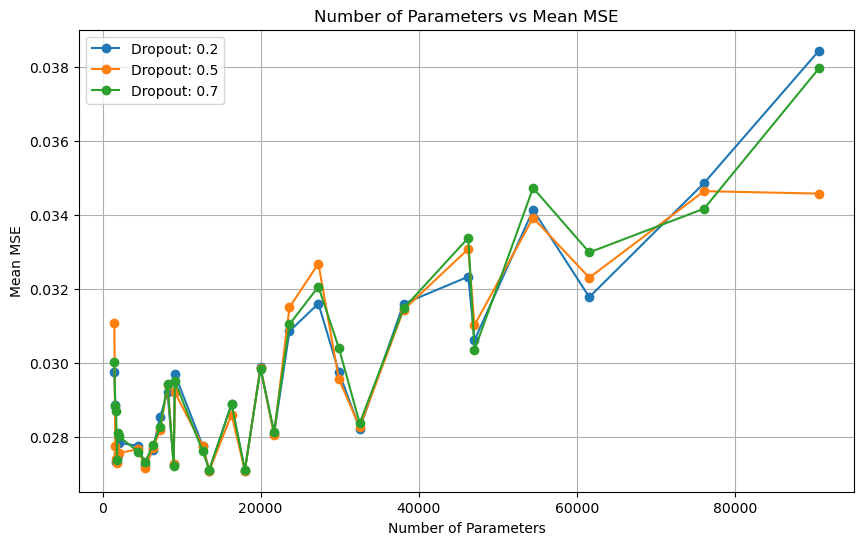

In [80]:
df = result_df.groupby(
    ['hidden_layer_dropout', 'num_params'],
    as_index=False
).agg(
    mean_mse = ('mse', 'mean')
)

plt.figure(figsize=(10, 6))
for dropout in df['hidden_layer_dropout'].unique():
    subset = df[df['hidden_layer_dropout'] == dropout]
    plt.plot(subset['num_params'], subset['mean_mse'], marker='o', label=f'Dropout: {dropout}')

plt.xlabel('Number of Parameters')
plt.ylabel('Mean MSE')
plt.title('Number of Parameters vs Mean MSE')
plt.legend()
plt.grid(True)
plt.show()

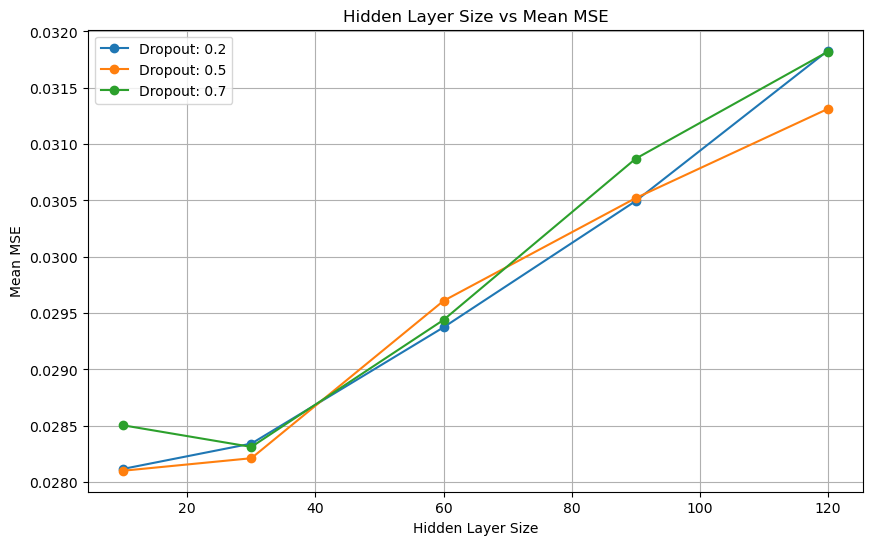

In [81]:
df = result_df.groupby(
    ['hidden_layer_dropout', 'hidden_size'],
    as_index=False
).agg(
    mean_mse = ('mse', 'mean')
)

plt.figure(figsize=(10, 6))
for dropout in df['hidden_layer_dropout'].unique():
    subset = df[df['hidden_layer_dropout'] == dropout]
    plt.plot(subset['hidden_size'], subset['mean_mse'], marker='o', label=f'Dropout: {dropout}')

plt.xlabel('Hidden Layer Size')
plt.ylabel('Mean MSE')
plt.title('Hidden Layer Size vs Mean MSE')
plt.legend()
plt.grid(True)
plt.show()

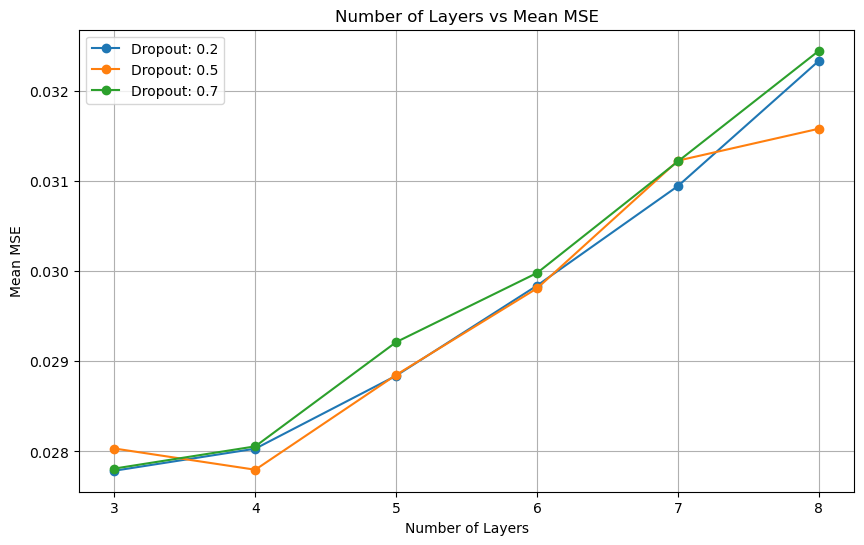

In [89]:
df = result_df.groupby(
    ['hidden_layer_dropout', 'num_hidden_layers'],
    as_index=False
).agg(
    mean_mse = ('mse', 'mean')
)

plt.figure(figsize=(10, 6))
for dropout in df['hidden_layer_dropout'].unique():
    subset = df[df['hidden_layer_dropout'] == dropout]
    plt.plot(subset['num_hidden_layers'] + 2, subset['mean_mse'], marker='o', label=f'Dropout: {dropout}')

plt.xlabel('Number of Layers')
plt.ylabel('Mean MSE')
plt.title('Number of Layers vs Mean MSE')
plt.legend()
plt.grid(True)
plt.show()

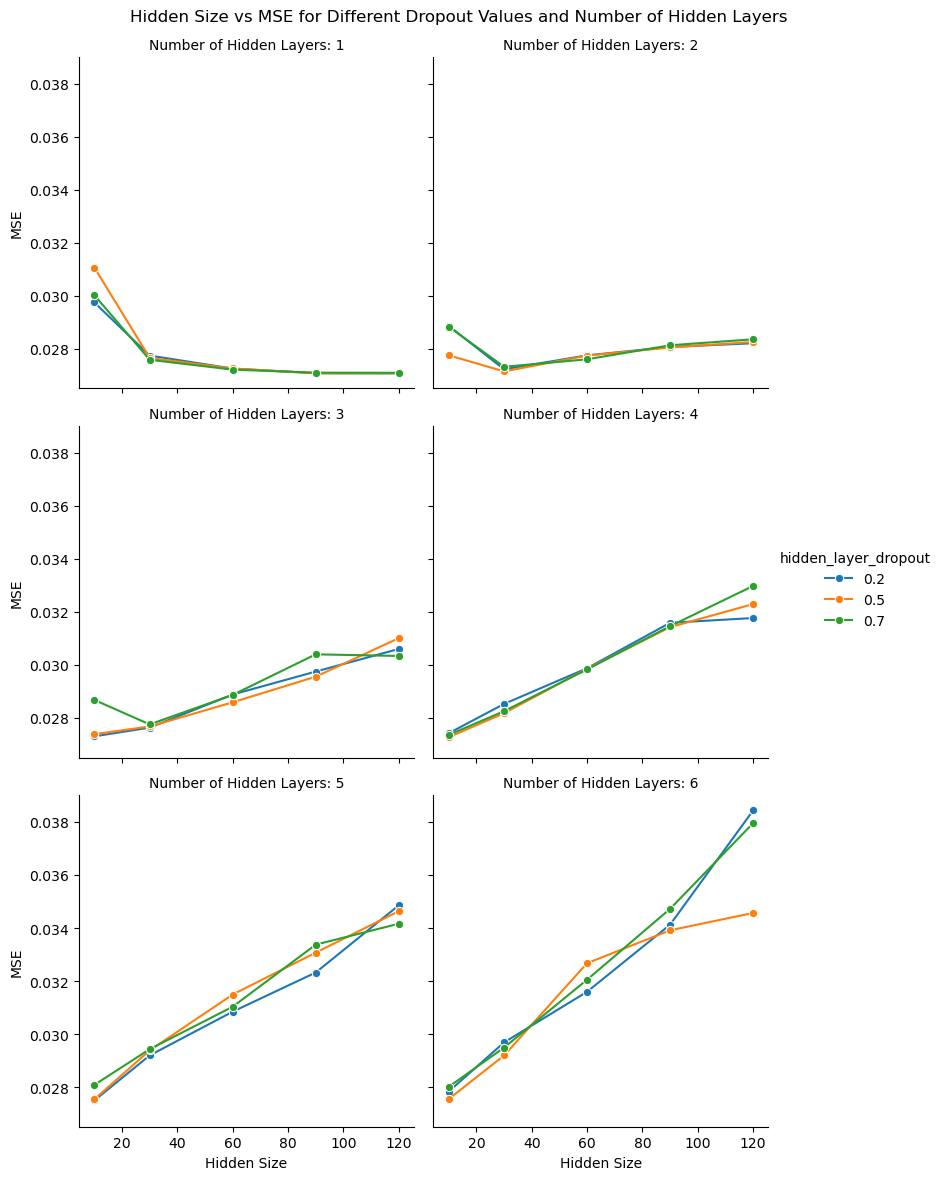

In [123]:
import seaborn as sns

# Plotting using seaborn
g = sns.FacetGrid(result_df, col="num_hidden_layers", hue="hidden_layer_dropout", height=4, aspect=1, col_wrap=2)
g.map(sns.lineplot, "hidden_size", "mse", marker="o")

g.add_legend()
g.set_axis_labels("Hidden Size", "MSE")
g.set_titles("Number of Hidden Layers: {col_name}")#, size=15)
plt.subplots_adjust(top=0.94)
g.fig.suptitle("Hidden Size vs MSE for Different Dropout Values and Number of Hidden Layers")#, size=20)

plt.show()